In [17]:
import pandas as pd
import numpy as np
from numpy import newaxis
import random
import itertools
import os
import math
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.collections
from matplotlib import gridspec
from sklearn.model_selection import train_test_split
from tqdm import *

import keras
from keras.applications import *
import lightgbm as lgbm
from scipy import stats
from keras.models import Sequential, Model
from keras.layers import * #Dense, Dropout, Activation, Flatten, Input,Concatenate, concatenate
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
import cv2 as cv
from os import listdir
from os.path import isfile, join
from scipy import misc
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score
from keras.utils.np_utils import to_categorical
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import Adam, RMSprop

In [3]:
plt.ion()
plt.show()

In [3]:
basedir = 'data/dogs/'
files = [f for f in listdir(basedir) if isfile(join(basedir, f))]
len(files)
img_size = 240

In [4]:
def normalize(arr):
    arr=arr.astype('float32')
    if arr.max() > 1.0:
        arr/=255.0
    return arr

def resizeImg(Xg):
#     cv.normalize(Xg,  Xg, 0, 1, cv.NORM_MINMAX)
#     Xg/=255.0
    Xg = normalize(Xg)
    if Xg.shape[0] >= img_size:
        return cv.resize(Xg,(img_size,img_size), cv.INTER_AREA)
    else:
        return cv.resize(Xg,(img_size,img_size), cv.INTER_CUBIC)

    
def readAndResize(filename):
    dog = misc.imread(basedir + filename)
    return resizeImg(dog)

(240, 240, 3)


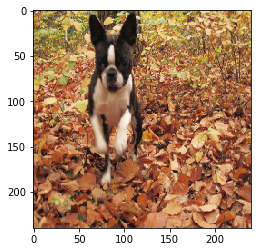

In [5]:
dog = readAndResize(files[0])
print(dog.shape)
plt.imshow(dog)
# readAndResize(files[0])

(375, 500, 3)


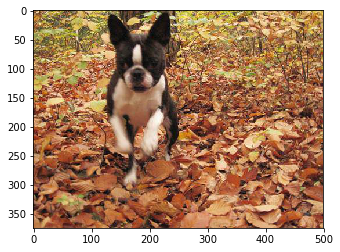

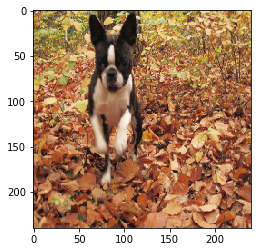

In [6]:
dog = misc.imread(basedir + files[0])
print(dog.shape)
plt.imshow(dog)
plt.show()
plt.imshow(resizeImg(dog))
plt.show()

In [7]:
def getInputImages(ids):
    data = [readAndResize(i) for i in  ids]
    data = np.stack(data)
    return data

In [8]:
from IPython.display import clear_output

class PlotLosses(keras.callbacks.Callback):
    def __init__(self):
        self.initVars()
    
    def initVars(self):
        self.i = 0
        self.x = []
        self.losses = []
        self.acc = [] #
        self.fig = plt.figure()
        self.logs = []
        self.lr = []

    def on_epoch_end(self, epoch, logs={}):     
        self.i += 1

        if self.i% 5 != 0:
            return
        
        self.losses.append(logs.get('loss'))

        self.acc.append(logs.get('acc'))
        self.logs.append(logs)
        self.x.append(self.i)
        
        clear_output(wait=True)
        plt.figure(figsize=(16,8))
        plt.subplot(1,3,1)
        self.plotLosses(None)

        

    def plotLosses(self, ax):
        plt.plot(self.x, self.losses, label="train loss")
        plt.plot(self.x, self.acc, label="accuracy")

        plt.legend()
        
        
myPlot = PlotLosses()
myPlot.initVars()

## GAN

In [14]:
img_size = 240
img_rows = img_size
img_cols = img_size
channels = 3
img_shape = (img_rows, img_cols, channels)
epochs = 100
batch_size = 20
save_interval= 10
half_batch = int(batch_size / 2)



In [18]:
def build_generator():

    noise_shape = (100,)
    noise = Input(shape=noise_shape)
    depth = 64 *4
    dim = 10

    x = Dense(dim * dim *depth, activation='relu', input_shape=noise_shape)(noise)
    x = BatchNormalization(momentum=0.9)(x)
#     x = LeakyReLU(alpha=0.2)(x)
    x = Reshape((dim, dim, depth))(x)
    x = Dropout(0.4)(x)
    
    x = UpSampling2D((4,4))(x)
    x = Conv2DTranspose(int(depth/2), 5, padding='same')(x)
    x = BatchNormalization(momentum=0.9)(x)
    
    x = UpSampling2D((3,3))(x)
    x = Conv2DTranspose(int(depth/4), 5, padding='same')(x)
    x = BatchNormalization(momentum=0.9)(x)
    
    x = UpSampling2D((2,2))(x)
    x = Conv2DTranspose(int(depth/8), 5, padding='same')(x)
    x = BatchNormalization(momentum=0.9)(x)
    
    
    x = Conv2DTranspose(3, 5, padding='same')(x)
    model = Model(noise, x)


    model.compile(optimizer=RMSprop(lr=0.0002, decay=6e-8), loss='binary_crossentropy', metrics=['accuracy'])
#     model.compile(optimizer=Adam(0.0001, 0.3), loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return Model(noise, x)

generator = build_generator()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 100)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 25600)             2585600   
_________________________________________________________________
batch_normalization_33 (Batc (None, 25600)             102400    
_________________________________________________________________
reshape_9 (Reshape)          (None, 10, 10, 256)       0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 10, 10, 256)       0         
_________________________________________________________________
up_sampling2d_23 (UpSampling (None, 40, 40, 256)       0         
_________________________________________________________________
conv2d_transpose_33 (Conv2DT (None, 40, 40, 128)       819328    
__________

In [19]:

def build_discriminator():
    img_shape = (img_rows, img_cols, channels)
    input_img = Input(shape=img_shape)
    depth = 64
    x = Convolution2D(depth, (5, 5), activation='relu', padding='same', input_shape=img_shape)(input_img)
    x = MaxPooling2D(pool_size=(2,2), padding='same') (x)
    x = LeakyReLU(0.2) (x)
    x = Dropout(0.6)(x)
    
    x = Convolution2D(depth *2 , (4, 4), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2,2), padding='same') (x)
    x = LeakyReLU(0.2) (x)
    x = Dropout(0.6)(x)
    
    x = Convolution2D(depth *4, (3, 3),  activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2,2), padding='same') (x)
    x = LeakyReLU(0.2) (x)
    x = Dropout(0.6)(x)
    
    x = Convolution2D(depth *8, (3, 3),  activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2,2), padding='same') (x)
    x = LeakyReLU(0.2) (x)
    x = Dropout(0.6)(x)

#     x = Convolution2D(16, (3, 3),  activation='relu', padding='same')(x)
#     x = MaxPooling2D(pool_size=(2,2), padding='same') (x)
#     x = Dropout(0.6)(x)
#     x= AveragePooling2D(pool_size=(4, 4), padding='valid')(x)
    x = Flatten(input_shape=img_shape)(x)
#     x = Dense(512)(x)
#     x = LeakyReLU(alpha=0.2)(x)
#     x = Dense(256)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dense(1, activation='sigmoid')(x)

    model = Model(input_img, x)

#     model.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy', metrics=['accuracy'])
#categorical_accuracy
    model.compile(optimizer=RMSprop(lr=0.0001, decay=3e-8), loss='binary_crossentropy', metrics=['accuracy'])
#     model.compile(optimizer=Adam(0.0001, 0.3), loss='categorical_crossentropy', metrics=['accuracy'])
    

    model.summary()
    return model

discriminator = build_discriminator()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 240, 240, 3)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 240, 240, 64)      4864      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 120, 120, 64)      0         
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 120, 120, 64)      0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 120, 120, 64)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 120, 120, 128)     131200    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 60, 60, 128)       0         
__________

In [12]:
def save_imgs(epoch):

    noise = np.random.normal(0, 1, (2, 100))
    gen_imgs = generator.predict(noise)
    fig = plt.figure(figsize =(8,12))
    plt.subplot(1,2,1)
    plt.imshow(gen_imgs[0])
    plt.subplot(1,2,2)
#     gen_imgs[1] = 0.5 * gen_imgs[1] + 0.5
    plt.imshow(gen_imgs[1])
    plt.show()
    # Rescale images 0 - 1
#     gen_imgs = 0.5 * gen_imgs + 0.5
#     fig = plt.figure(figsize =())
#     fig, axs = plt.subplots(r, c)
#     cnt = 0
#     for i in range(r):
#         for j in range(c):
#             axs[i,j].imshow(gen_imgs[cnt, :,:,0])
#             axs[i,j].axis('off')
#             cnt += 1
#     plt.show()
#     fig.savefig("gan/images/mnist_%d.png" % epoch)
#     plt.close()


In [56]:
to_categorical(np.ones((2, 1)))

array([[ 0.,  1.],
       [ 0.,  1.]])

## Test discriminator

In [23]:
def getData(size):
    idx = list(np.random.randint(0, len(files), size))
    imgs = getInputImages([files[i] for i in idx])
    noise = np.random.normal(0, 1, (size, 100))
    gen_imgs = generator.predict(noise)
    d_input = np.append(imgs, gen_imgs, axis=0)

    d_output = np.append(np.ones((size, 1), dtype=np.int), np.zeros((size, 1)), axis=0)

    return d_input, d_output
    

In [19]:
getData(2)
1

d_output  [[ 1.]
 [ 1.]
 [ 0.]
 [ 0.]]


1

In [1]:
# half_batch = 2
# for epoch in range(100):

#     d_input, d_output = getData(half_batch)
#     discriminator.fit(d_input, d_output, epochs = 1)
#     pred1 = discriminator.predict(d_input)

    
#     t_input, t_output = getData(2)

#     pred = (discriminator.predict(t_input) > 0.5).astype(int)

#     print('accuracy_score : ' , accuracy_score(pred, t_output))


history :  {'acc': [0.43333333730697632, 0.5], 'loss': [0.70193642377853394, 2.096714973449707], 'lr': [0.001, 0.001]}
g_loss :  1.19209e-07


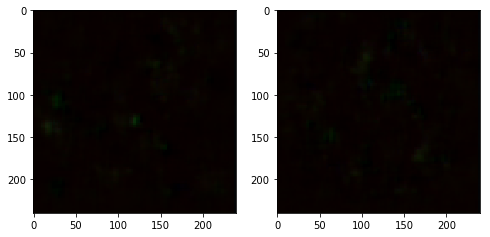

history :  {'acc': [0.5, 0.5], 'loss': [0.51317358016967773, 0.35211136937141418], 'lr': [0.001, 0.001]}
g_loss :  1.19209e-07
history :  {'acc': [1.0, 1.0], 'loss': [0.34361392259597778, 0.35734501481056213], 'lr': [0.001, 0.001]}
g_loss :  1.19209e-07
history :  {'acc': [1.0, 1.0], 'loss': [0.34627854824066162, 0.31825408339500427], 'lr': [0.001, 0.001]}
g_loss :  1.19209e-07
history :  {'acc': [1.0, 1.0], 'loss': [0.29694172739982605, 0.27800092101097107], 'lr': [0.001, 0.001]}
g_loss :  1.19209e-07
history :  {'acc': [1.0, 1.0], 'loss': [0.25672069191932678, 0.22383935749530792], 'lr': [0.001, 0.001]}
g_loss :  1.19209e-07


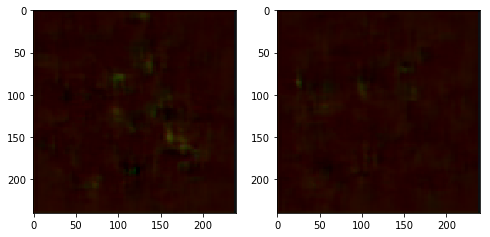

history :  {'acc': [1.0, 1.0], 'loss': [0.18871802091598511, 0.14737185835838318], 'lr': [0.001, 0.001]}
g_loss :  1.19209e-07
history :  {'acc': [1.0, 1.0], 'loss': [0.11481594294309616, 0.080158717930316925], 'lr': [0.001, 0.001]}
g_loss :  1.19209e-07
history :  {'acc': [1.0, 1.0], 'loss': [0.040974147617816925, 0.018578896299004555], 'lr': [0.001, 0.001]}
g_loss :  1.19209e-07
history :  {'acc': [1.0, 1.0], 'loss': [0.0063894400373101234, 0.0024265612009912729], 'lr': [0.001, 0.001]}
g_loss :  1.19209e-07
history :  {'acc': [1.0, 1.0], 'loss': [0.00050180597463622689, 0.00018628781253937632], 'lr': [0.001, 0.001]}
g_loss :  1.19209e-07


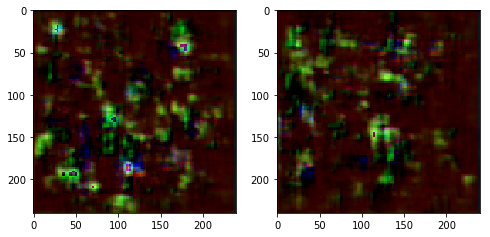

history :  {'acc': [1.0, 1.0], 'loss': [6.8630564783234149e-05, 1.6743668311391957e-05], 'lr': [0.001, 0.001]}
g_loss :  1.19209e-07
history :  {'acc': [0.96666663885116577, 0.76666665077209473], 'loss': [0.19007442891597748, 0.6903272271156311], 'lr': [0.001, 0.001]}
g_loss :  1.19209e-07
history :  {'acc': [0.80000001192092896, 0.96666663885116577], 'loss': [0.54336732625961304, 0.07640569657087326], 'lr': [0.001, 0.001]}
g_loss :  16.1007
history :  {'acc': [0.5, 0.60000002384185791], 'loss': [2.4800794124603271, 2.5868239402770996], 'lr': [0.001, 0.001]}
g_loss :  16.1181
history :  {'acc': [0.93333333730697632, 1.0], 'loss': [0.16883113980293274, 0.030274059623479843], 'lr': [0.001, 0.001]}
g_loss :  15.9552


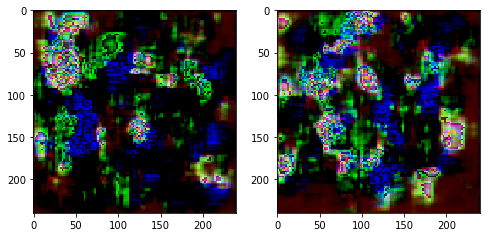

history :  {'acc': [0.80000001192092896, 0.89999997615814209], 'loss': [1.0247606039047241, 0.2052152007818222], 'lr': [0.001, 0.001]}
g_loss :  16.1181
history :  {'acc': [0.66666668653488159, 0.69999998807907104], 'loss': [0.70623624324798584, 0.60627478361129761], 'lr': [0.001, 0.001]}
g_loss :  16.1181
history :  {'acc': [1.0, 1.0], 'loss': [0.043685201555490494, 0.014911442063748837], 'lr': [0.001, 0.001]}
g_loss :  15.5875
history :  {'acc': [0.66666668653488159, 1.0], 'loss': [0.86752647161483765, 0.013887081295251846], 'lr': [0.001, 0.001]}
g_loss :  16.1181
history :  {'acc': [1.0, 1.0], 'loss': [0.026872130110859871, 0.071954220533370972], 'lr': [0.001, 0.001]}
g_loss :  16.1181


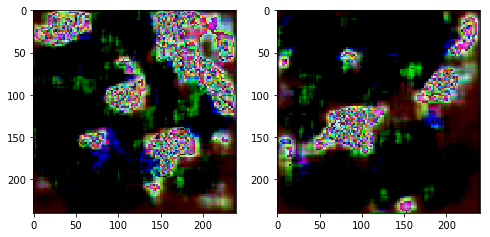

history :  {'acc': [0.89999997615814209, 0.89999997615814209], 'loss': [0.18538752198219299, 0.20466808974742889], 'lr': [0.001, 0.001]}
g_loss :  16.1181
history :  {'acc': [1.0, 1.0], 'loss': [0.066707342863082886, 0.02252458781003952], 'lr': [0.001, 0.001]}
g_loss :  16.1181
history :  {'acc': [1.0, 1.0], 'loss': [0.0075112106278538704, 0.0018450546776875854], 'lr': [0.001, 0.001]}
g_loss :  16.1181
history :  {'acc': [1.0, 1.0], 'loss': [0.0011488806921988726, 0.00047045538667589426], 'lr': [0.001, 0.001]}
g_loss :  16.1181
history :  {'acc': [1.0, 1.0], 'loss': [0.0016472033457830548, 0.0072749829851090908], 'lr': [0.001, 0.001]}
g_loss :  15.8654


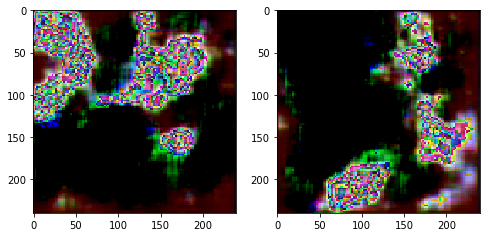

history :  {'acc': [0.56666666269302368, 1.0], 'loss': [2.338874340057373, 0.0018901011208072305], 'lr': [0.001, 0.001]}
g_loss :  16.1181
history :  {'acc': [0.93333333730697632, 0.56666666269302368], 'loss': [0.19297249615192413, 2.2165343761444092], 'lr': [0.001, 0.001]}
g_loss :  16.1181
history :  {'acc': [0.63333332538604736, 0.76666665077209473], 'loss': [1.3788784742355347, 0.56466978788375854], 'lr': [0.001, 0.001]}
g_loss :  16.1181
history :  {'acc': [1.0, 1.0], 'loss': [0.12415526062250137, 0.045232422649860382], 'lr': [0.001, 0.001]}
g_loss :  16.1181
history :  {'acc': [1.0, 1.0], 'loss': [0.039816472679376602, 0.061328422278165817], 'lr': [0.001, 0.001]}
g_loss :  14.9514


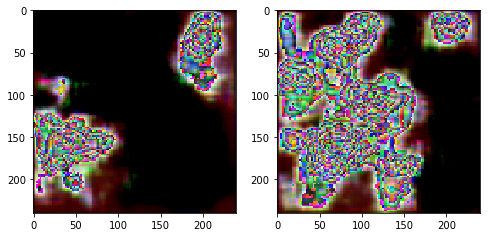

history :  {'acc': [0.80000001192092896, 0.83333331346511841], 'loss': [0.53329598903656006, 0.43674153089523315], 'lr': [0.001, 0.001]}
g_loss :  14.2753
history :  {'acc': [0.80000001192092896, 0.93333333730697632], 'loss': [0.84799271821975708, 0.1870289146900177], 'lr': [0.001, 0.001]}
g_loss :  15.6957
history :  {'acc': [0.93333333730697632, 0.69999998807907104], 'loss': [0.21586643159389496, 0.40891918540000916], 'lr': [0.001, 0.001]}
g_loss :  16.1181
history :  {'acc': [0.56666666269302368, 0.60000002384185791], 'loss': [0.50806480646133423, 0.46363875269889832], 'lr': [0.001, 0.001]}
g_loss :  16.1181
history :  {'acc': [0.63333332538604736, 0.69999998807907104], 'loss': [0.5495874285697937, 0.42382428050041199], 'lr': [0.001, 0.001]}
g_loss :  15.722


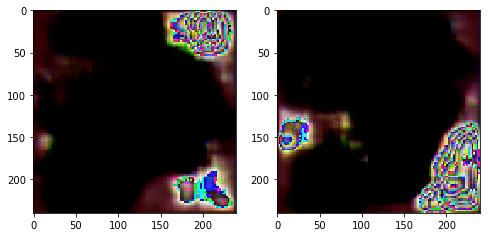

history :  {'acc': [0.86666667461395264, 0.96666663885116577], 'loss': [0.28623977303504944, 0.21198545396327972], 'lr': [0.001, 0.001]}
g_loss :  11.066
history :  {'acc': [0.80000001192092896, 0.80000001192092896], 'loss': [0.41327443718910217, 0.42003712058067322], 'lr': [0.001, 0.001]}
g_loss :  9.48477
history :  {'acc': [0.83333331346511841, 0.86666667461395264], 'loss': [0.49788758158683777, 0.42080587148666382], 'lr': [0.001, 0.001]}
g_loss :  7.91637
history :  {'acc': [0.86666667461395264, 0.89999997615814209], 'loss': [0.48283663392066956, 0.38717144727706909], 'lr': [0.001, 0.001]}
g_loss :  9.16727
history :  {'acc': [0.93333333730697632, 0.86666667461395264], 'loss': [0.31412327289581299, 0.31859001517295837], 'lr': [0.001, 0.001]}
g_loss :  7.59561


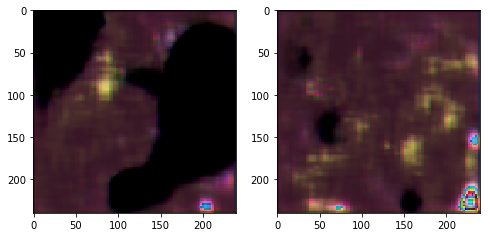

history :  {'acc': [0.80000001192092896, 0.80000001192092896], 'loss': [0.52674287557601929, 0.50523883104324341], 'lr': [0.001, 0.001]}
g_loss :  5.64124
history :  {'acc': [0.86666667461395264, 0.86666667461395264], 'loss': [0.43499353528022766, 0.41282364726066589], 'lr': [0.001, 0.001]}
g_loss :  6.32081
history :  {'acc': [0.69999998807907104, 0.69999998807907104], 'loss': [0.89552885293960571, 0.74878305196762085], 'lr': [0.001, 0.001]}
g_loss :  5.25589
history :  {'acc': [0.86666667461395264, 0.86666667461395264], 'loss': [0.37637028098106384, 0.36508452892303467], 'lr': [0.001, 0.001]}
g_loss :  3.22914
history :  {'acc': [0.69999998807907104, 0.69999998807907104], 'loss': [0.57842618227005005, 0.53757017850875854], 'lr': [0.001, 0.001]}
g_loss :  3.83749


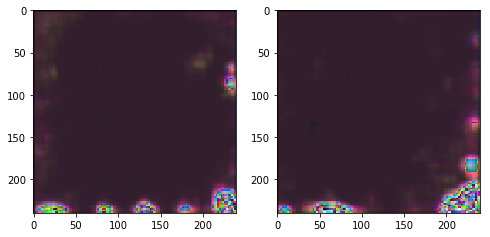

history :  {'acc': [0.56666666269302368, 0.56666666269302368], 'loss': [0.63853919506072998, 0.56467783451080322], 'lr': [0.001, 0.001]}
g_loss :  5.05441
history :  {'acc': [0.69999998807907104, 0.83333331346511841], 'loss': [0.57461285591125488, 0.52907484769821167], 'lr': [0.001, 0.001]}
g_loss :  4.38067
history :  {'acc': [0.76666665077209473, 0.86666667461395264], 'loss': [0.48729118704795837, 0.40589180588722229], 'lr': [0.001, 0.001]}
g_loss :  2.99188
history :  {'acc': [0.83333331346511841, 0.89999997615814209], 'loss': [0.46257477998733521, 0.4201698899269104], 'lr': [0.001, 0.001]}
g_loss :  1.19652
history :  {'acc': [0.63333332538604736, 0.80000001192092896], 'loss': [0.91985011100769043, 0.54579579830169678], 'lr': [0.001, 0.001]}
g_loss :  5.06962


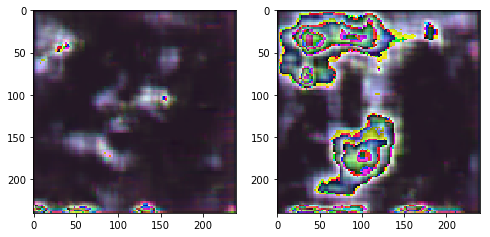

history :  {'acc': [0.23333333432674408, 0.56666666269302368], 'loss': [2.1210281848907471, 1.6913484334945679], 'lr': [0.001, 0.001]}
g_loss :  9.62426
history :  {'acc': [0.5, 0.5], 'loss': [2.0271265506744385, 1.326543927192688], 'lr': [0.001, 0.001]}
g_loss :  5.58351
history :  {'acc': [0.43333333730697632, 0.83333331346511841], 'loss': [0.99312788248062134, 0.70604622364044189], 'lr': [0.001, 0.001]}
g_loss :  2.96633
history :  {'acc': [0.76666665077209473, 0.80000001192092896], 'loss': [0.53893077373504639, 0.49397090077400208], 'lr': [0.001, 0.001]}
g_loss :  4.50352
history :  {'acc': [0.83333331346511841, 0.86666667461395264], 'loss': [0.52052611112594604, 0.5105893611907959], 'lr': [0.001, 0.001]}
g_loss :  6.02222


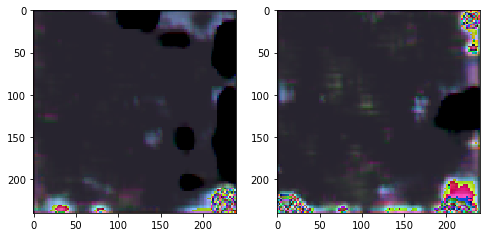

history :  {'acc': [0.76666665077209473, 0.89999997615814209], 'loss': [0.54551833868026733, 0.47414198517799377], 'lr': [0.001, 0.001]}
g_loss :  8.88784
history :  {'acc': [0.86666667461395264, 0.89999997615814209], 'loss': [0.44412288069725037, 0.37306815385818481], 'lr': [0.001, 0.001]}
g_loss :  7.15417
history :  {'acc': [0.69999998807907104, 0.76666665077209473], 'loss': [0.62210851907730103, 0.54296630620956421], 'lr': [0.001, 0.001]}
g_loss :  5.76111
history :  {'acc': [0.66666668653488159, 0.69999998807907104], 'loss': [0.55167490243911743, 0.45951473712921143], 'lr': [0.001, 0.001]}
g_loss :  3.62854
history :  {'acc': [0.73333334922790527, 0.73333334922790527], 'loss': [0.53377002477645874, 0.49153622984886169], 'lr': [0.001, 0.001]}
g_loss :  4.13429


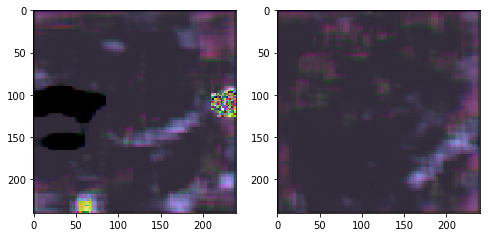

history :  {'acc': [0.69999998807907104, 0.80000001192092896], 'loss': [0.45065209269523621, 0.40886542201042175], 'lr': [0.001, 0.001]}
g_loss :  4.95416
history :  {'acc': [0.80000001192092896, 0.86666667461395264], 'loss': [0.41396147012710571, 0.35844612121582031], 'lr': [0.001, 0.001]}
g_loss :  7.38279
history :  {'acc': [0.89999997615814209, 0.83333331346511841], 'loss': [0.31068429350852966, 0.32896825671195984], 'lr': [0.001, 0.001]}
g_loss :  5.17186
history :  {'acc': [0.69999998807907104, 0.69999998807907104], 'loss': [0.41201826930046082, 0.49126848578453064], 'lr': [0.001, 0.001]}
g_loss :  4.19868
history :  {'acc': [0.80000001192092896, 0.80000001192092896], 'loss': [0.32468900084495544, 0.32046857476234436], 'lr': [0.001, 0.001]}
g_loss :  7.48858


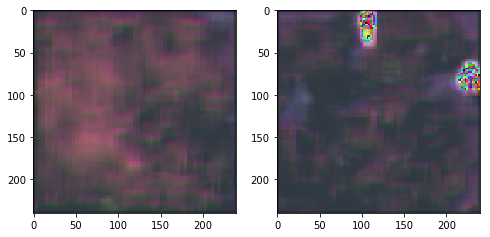

history :  {'acc': [0.80000001192092896, 0.83333331346511841], 'loss': [0.29710978269577026, 0.258279949426651], 'lr': [0.001, 0.001]}
g_loss :  6.49903
history :  {'acc': [0.76666665077209473, 0.76666665077209473], 'loss': [0.3470187783241272, 0.30432978272438049], 'lr': [0.001, 0.001]}
g_loss :  6.53061
history :  {'acc': [0.76666665077209473, 0.80000001192092896], 'loss': [0.36512613296508789, 0.23739661276340485], 'lr': [0.001, 0.001]}
g_loss :  5.31653
history :  {'acc': [0.73333334922790527, 0.96666663885116577], 'loss': [0.35451644659042358, 0.27139323949813843], 'lr': [0.001, 0.001]}
g_loss :  4.70866
history :  {'acc': [0.73333334922790527, 0.80000001192092896], 'loss': [1.0651130676269531, 0.98826736211776733], 'lr': [0.001, 0.001]}
g_loss :  2.98565


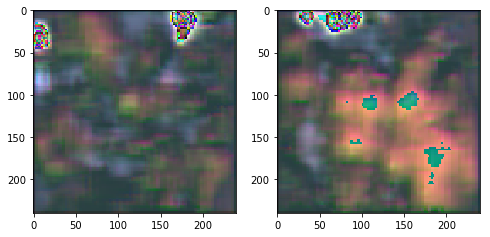

history :  {'acc': [0.76666665077209473, 0.5], 'loss': [0.70178413391113281, 1.1012321710586548], 'lr': [0.001, 0.001]}
g_loss :  3.2565
history :  {'acc': [0.53333336114883423, 0.73333334922790527], 'loss': [2.8715033531188965, 1.6623426675796509], 'lr': [0.001, 0.001]}
g_loss :  6.32973
history :  {'acc': [0.5, 0.5], 'loss': [1.0270787477493286, 1.2056556940078735], 'lr': [0.001, 0.001]}
g_loss :  5.87415
history :  {'acc': [0.56666666269302368, 0.63333332538604736], 'loss': [0.78065109252929688, 0.57933294773101807], 'lr': [0.001, 0.001]}
g_loss :  4.007
history :  {'acc': [0.60000002384185791, 0.53333336114883423], 'loss': [0.65017569065093994, 0.67119324207305908], 'lr': [0.001, 0.001]}
g_loss :  3.21797


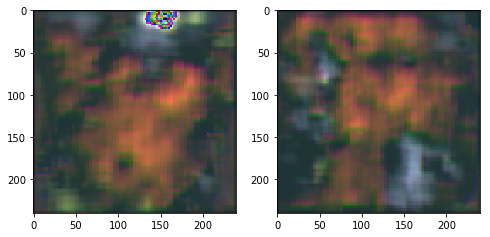

history :  {'acc': [0.60000002384185791, 0.63333332538604736], 'loss': [0.79169267416000366, 0.71780788898468018], 'lr': [0.001, 0.001]}
g_loss :  2.96434
history :  {'acc': [0.56666666269302368, 0.60000002384185791], 'loss': [0.72790420055389404, 0.65091592073440552], 'lr': [0.001, 0.001]}
g_loss :  2.64789
history :  {'acc': [0.46666666865348816, 0.5], 'loss': [0.62580490112304688, 0.61454761028289795], 'lr': [0.001, 0.001]}
g_loss :  1.66964
history :  {'acc': [0.66666668653488159, 0.73333334922790527], 'loss': [0.61561614274978638, 0.61006247997283936], 'lr': [0.001, 0.001]}
g_loss :  1.13823
history :  {'acc': [0.56666666269302368, 0.60000002384185791], 'loss': [0.61010479927062988, 0.60470998287200928], 'lr': [0.001, 0.001]}
g_loss :  1.46014


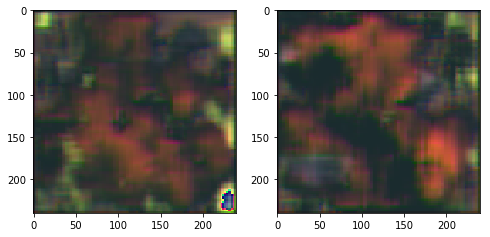

history :  {'acc': [0.46666666865348816, 0.43333333730697632], 'loss': [0.71484655141830444, 0.67775845527648926], 'lr': [0.001, 0.001]}
g_loss :  0.230385
history :  {'acc': [0.46666666865348816, 0.43333333730697632], 'loss': [0.72716712951660156, 0.68061703443527222], 'lr': [0.001, 0.001]}
g_loss :  0.0159985
history :  {'acc': [0.69999998807907104, 0.69999998807907104], 'loss': [0.64898389577865601, 0.61339884996414185], 'lr': [0.001, 0.001]}
g_loss :  0.832847
history :  {'acc': [0.76666665077209473, 0.80000001192092896], 'loss': [0.58717131614685059, 0.55760294198989868], 'lr': [0.001, 0.001]}
g_loss :  1.3896
history :  {'acc': [0.89999997615814209, 0.89999997615814209], 'loss': [0.55103570222854614, 0.50863808393478394], 'lr': [0.001, 0.001]}
g_loss :  1.505


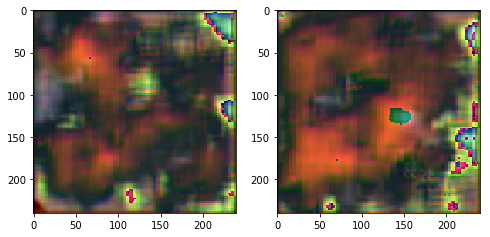

history :  {'acc': [0.89999997615814209, 0.83333331346511841], 'loss': [0.52407246828079224, 0.47483313083648682], 'lr': [0.001, 0.001]}
g_loss :  1.89807
history :  {'acc': [0.80000001192092896, 0.83333331346511841], 'loss': [0.55407452583312988, 0.53935271501541138], 'lr': [0.001, 0.001]}
g_loss :  3.86436
history :  {'acc': [0.60000002384185791, 0.60000002384185791], 'loss': [0.70535331964492798, 0.67027288675308228], 'lr': [0.001, 0.001]}
g_loss :  4.76384
history :  {'acc': [0.53333336114883423, 0.5], 'loss': [1.1560930013656616, 0.99060720205307007], 'lr': [0.001, 0.001]}
g_loss :  4.00487
history :  {'acc': [0.46666666865348816, 0.5], 'loss': [1.0397460460662842, 0.69447970390319824], 'lr': [0.001, 0.001]}
g_loss :  5.27898


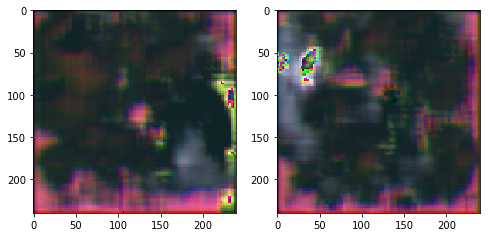

history :  {'acc': [0.83333331346511841, 0.89999997615814209], 'loss': [0.47873470187187195, 0.37838026881217957], 'lr': [0.001, 0.001]}
g_loss :  4.222
history :  {'acc': [0.73333334922790527, 0.69999998807907104], 'loss': [0.49652263522148132, 0.45923072099685669], 'lr': [0.001, 0.001]}
g_loss :  2.95024
history :  {'acc': [0.89999997615814209, 0.96666663885116577], 'loss': [0.4259360134601593, 0.37049001455307007], 'lr': [0.001, 0.001]}
g_loss :  3.56433
history :  {'acc': [0.96666663885116577, 0.96666663885116577], 'loss': [0.25339376926422119, 0.18481650948524475], 'lr': [0.001, 0.001]}
g_loss :  2.92262
history :  {'acc': [0.89999997615814209, 0.96666663885116577], 'loss': [0.32540690898895264, 0.23691649734973907], 'lr': [0.001, 0.001]}
g_loss :  2.12855


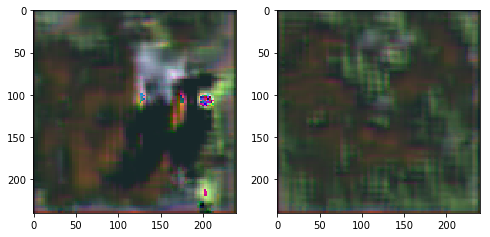

history :  {'acc': [0.96666663885116577, 0.96666663885116577], 'loss': [0.09334583580493927, 0.06917060911655426], 'lr': [0.001, 0.001]}
g_loss :  4.74604
history :  {'acc': [0.93333333730697632, 0.96666663885116577], 'loss': [0.19872421026229858, 0.13641159236431122], 'lr': [0.001, 0.001]}
g_loss :  3.41549
history :  {'acc': [0.76666665077209473, 0.66666668653488159], 'loss': [0.56837433576583862, 0.58049875497817993], 'lr': [0.001, 0.001]}
g_loss :  1.85162
history :  {'acc': [0.86666667461395264, 0.86666667461395264], 'loss': [0.42195719480514526, 0.25694635510444641], 'lr': [0.001, 0.001]}
g_loss :  11.4896
history :  {'acc': [0.83333331346511841, 0.89999997615814209], 'loss': [0.6380845308303833, 0.26279616355895996], 'lr': [0.001, 0.001]}
g_loss :  4.96529


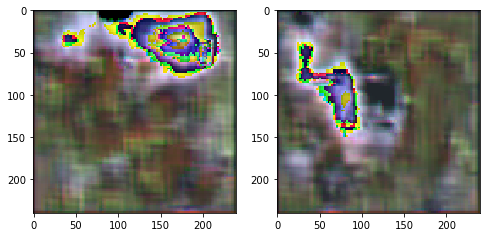

history :  {'acc': [0.83333331346511841, 0.76666665077209473], 'loss': [0.30120208859443665, 0.3616010844707489], 'lr': [0.001, 0.001]}
g_loss :  4.70885
history :  {'acc': [0.89999997615814209, 0.86666667461395264], 'loss': [0.30621537566184998, 0.32097211480140686], 'lr': [0.001, 0.001]}
g_loss :  5.355
history :  {'acc': [0.83333331346511841, 0.93333333730697632], 'loss': [0.33712074160575867, 0.14389209449291229], 'lr': [0.001, 0.001]}
g_loss :  3.18761
history :  {'acc': [1.0, 1.0], 'loss': [0.10030802339315414, 0.077850297093391418], 'lr': [0.001, 0.001]}
g_loss :  2.38362
history :  {'acc': [0.96666663885116577, 0.93333333730697632], 'loss': [0.11255804449319839, 0.15587712824344635], 'lr': [0.001, 0.001]}
g_loss :  2.43397


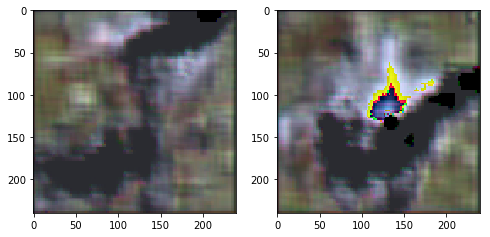

history :  {'acc': [0.93333333730697632, 0.89999997615814209], 'loss': [0.48395839333534241, 0.31843262910842896], 'lr': [0.001, 0.001]}
g_loss :  1.99858
history :  {'acc': [0.93333333730697632, 1.0], 'loss': [0.10638811439275742, 0.060525886714458466], 'lr': [0.001, 0.001]}
g_loss :  1.21235
history :  {'acc': [1.0, 1.0], 'loss': [0.079722948372364044, 0.095001772046089172], 'lr': [0.001, 0.001]}
g_loss :  3.03753
history :  {'acc': [0.96666663885116577, 0.96666663885116577], 'loss': [0.14104925096035004, 0.14750078320503235], 'lr': [0.001, 0.001]}
g_loss :  2.28214
history :  {'acc': [0.93333333730697632, 0.93333333730697632], 'loss': [0.13349609076976776, 0.20546126365661621], 'lr': [0.001, 0.001]}
g_loss :  3.11608


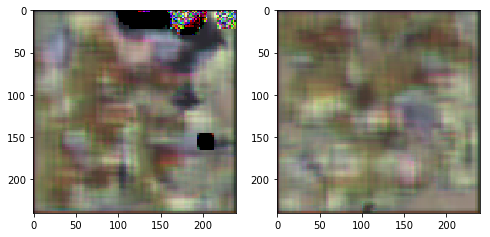

history :  {'acc': [0.86666667461395264, 0.66666668653488159], 'loss': [0.21388150751590729, 0.42160910367965698], 'lr': [0.001, 0.001]}
g_loss :  1.30242
history :  {'acc': [0.96666663885116577, 0.89999997615814209], 'loss': [0.22654935717582703, 0.34996995329856873], 'lr': [0.001, 0.001]}
g_loss :  1.88366
history :  {'acc': [0.73333334922790527, 0.89999997615814209], 'loss': [0.61253035068511963, 0.2437710165977478], 'lr': [0.001, 0.001]}
g_loss :  6.03594
history :  {'acc': [1.0, 0.89999997615814209], 'loss': [0.032537158578634262, 0.13462813198566437], 'lr': [0.001, 0.001]}
g_loss :  4.47704
history :  {'acc': [0.96666663885116577, 0.86666667461395264], 'loss': [0.098188385367393494, 0.16189081966876984], 'lr': [0.001, 0.001]}
g_loss :  4.12741


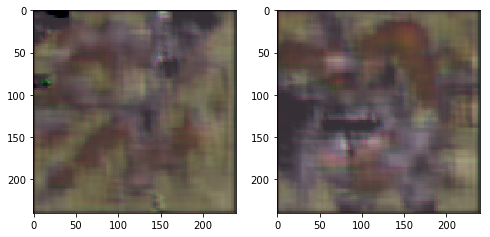

history :  {'acc': [1.0, 1.0], 'loss': [0.093410059809684753, 0.052470285445451736], 'lr': [0.001, 0.001]}
g_loss :  3.31009
history :  {'acc': [1.0, 1.0], 'loss': [0.027750551700592041, 0.031383004039525986], 'lr': [0.001, 0.001]}
g_loss :  4.58331
history :  {'acc': [1.0, 1.0], 'loss': [0.035113763064146042, 0.043629515916109085], 'lr': [0.001, 0.001]}
g_loss :  6.09428
history :  {'acc': [0.96666663885116577, 1.0], 'loss': [0.065451003611087799, 0.063639633357524872], 'lr': [0.001, 0.001]}
g_loss :  3.727
history :  {'acc': [0.93333333730697632, 0.96666663885116577], 'loss': [0.07800089567899704, 0.064206212759017944], 'lr': [0.001, 0.001]}
g_loss :  2.10797


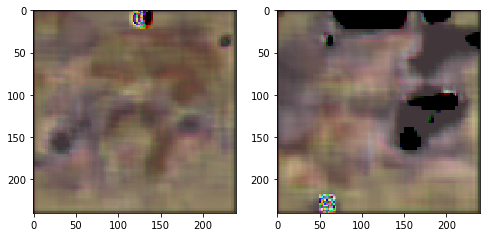

history :  {'acc': [1.0, 1.0], 'loss': [0.033483665436506271, 0.029793879017233849], 'lr': [0.001, 0.001]}
g_loss :  2.55142
history :  {'acc': [1.0, 1.0], 'loss': [0.040528062731027603, 0.036716654896736145], 'lr': [0.001, 0.001]}
g_loss :  2.15421
history :  {'acc': [1.0, 1.0], 'loss': [0.019966356456279755, 0.016013991087675095], 'lr': [0.001, 0.001]}
g_loss :  1.55069
history :  {'acc': [1.0, 1.0], 'loss': [0.015227077528834343, 0.0098362993448972702], 'lr': [0.001, 0.001]}
g_loss :  2.97856
history :  {'acc': [1.0, 1.0], 'loss': [0.0072724344208836555, 0.0050519807264208794], 'lr': [0.001, 0.001]}
g_loss :  2.17641


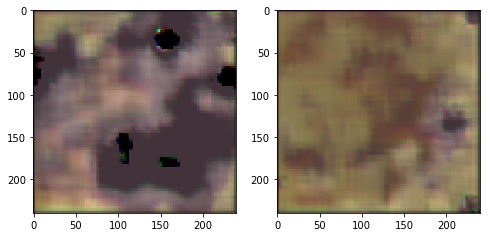

history :  {'acc': [1.0, 1.0], 'loss': [0.0068253814242780209, 0.0062528355047106743], 'lr': [0.001, 0.001]}
g_loss :  0.798874
history :  {'acc': [1.0, 1.0], 'loss': [0.013053139671683311, 0.0085037210956215858], 'lr': [0.001, 0.001]}
g_loss :  2.14908
history :  {'acc': [1.0, 1.0], 'loss': [0.02419525571167469, 0.016533685848116875], 'lr': [0.001, 0.001]}
g_loss :  2.68875
history :  {'acc': [1.0, 1.0], 'loss': [0.005055679939687252, 0.0051393108442425728], 'lr': [0.001, 0.001]}
g_loss :  0.541755
history :  {'acc': [1.0, 1.0], 'loss': [0.023155225440859795, 0.021723471581935883], 'lr': [0.001, 0.001]}
g_loss :  1.62631


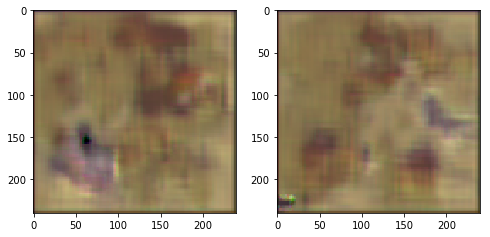

history :  {'acc': [1.0, 1.0], 'loss': [0.0026228711940348148, 0.0020941779948771], 'lr': [0.001, 0.001]}
g_loss :  0.572392
history :  {'acc': [1.0, 1.0], 'loss': [0.0047649787738919258, 0.0057331258431077003], 'lr': [0.001, 0.001]}
g_loss :  1.04965
history :  {'acc': [1.0, 1.0], 'loss': [0.0022969236597418785, 0.0022957208566367626], 'lr': [0.001, 0.001]}
g_loss :  0.53727
history :  {'acc': [0.96666663885116577, 0.96666663885116577], 'loss': [0.040319740772247314, 0.044294875115156174], 'lr': [0.001, 0.001]}
g_loss :  1.61181
history :  {'acc': [1.0, 1.0], 'loss': [0.024728091433644295, 0.016404354944825172], 'lr': [0.001, 0.001]}
g_loss :  0.537296


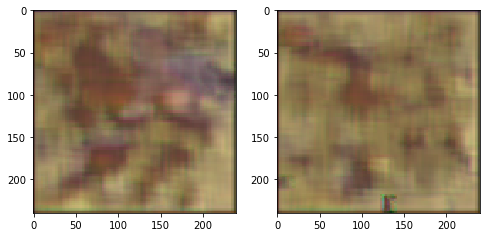

history :  {'acc': [1.0, 1.0], 'loss': [0.0083917360752820969, 0.033375672996044159], 'lr': [0.001, 0.001]}
g_loss :  1.63584
history :  {'acc': [1.0, 1.0], 'loss': [0.026616198942065239, 0.006364443339407444], 'lr': [0.001, 0.001]}
g_loss :  1.58113
history :  {'acc': [1.0, 1.0], 'loss': [0.0039648646488785744, 0.0018646176904439926], 'lr': [0.001, 0.001]}
g_loss :  1.07456
history :  {'acc': [1.0, 1.0], 'loss': [0.0037328226026147604, 0.0061844079755246639], 'lr': [0.001, 0.001]}
g_loss :  0.53727
history :  {'acc': [1.0, 1.0], 'loss': [0.0011734842555597425, 0.0009078521397896111], 'lr': [0.001, 0.001]}
g_loss :  1.30864


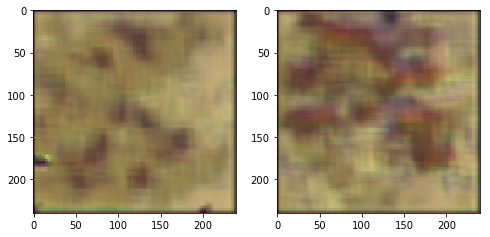

history :  {'acc': [0.93333333730697632, 1.0], 'loss': [0.14045287668704987, 0.033903200179338455], 'lr': [0.001, 0.001]}
g_loss :  1.22779
history :  {'acc': [1.0, 1.0], 'loss': [0.025194985792040825, 0.074173882603645325], 'lr': [0.001, 0.001]}
g_loss :  0.53727
history :  {'acc': [1.0, 1.0], 'loss': [0.0035454833414405584, 0.0020335325971245766], 'lr': [0.001, 0.001]}
g_loss :  0.856334
history :  {'acc': [1.0, 1.0], 'loss': [0.0091207157820463181, 0.018847903236746788], 'lr': [0.001, 0.001]}
g_loss :  2.36142
history :  {'acc': [1.0, 1.0], 'loss': [0.018373394384980202, 0.0068129091523587704], 'lr': [0.001, 0.001]}
g_loss :  2.27935


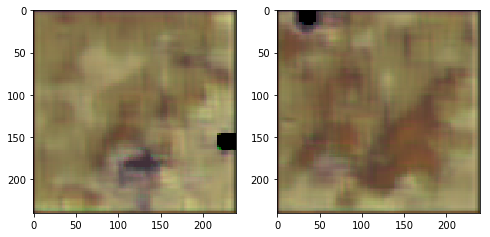

history :  {'acc': [1.0, 1.0], 'loss': [0.010663679800927639, 0.010771007277071476], 'lr': [0.001, 0.001]}
g_loss :  1.52611
history :  {'acc': [0.93333333730697632, 0.93333333730697632], 'loss': [0.18800096213817596, 0.22233042120933533], 'lr': [0.001, 0.001]}
g_loss :  0.53727
history :  {'acc': [1.0, 1.0], 'loss': [0.005220106802880764, 0.0013149013975635171], 'lr': [0.001, 0.001]}
g_loss :  0.673125
history :  {'acc': [1.0, 0.96666663885116577], 'loss': [0.0070510893128812313, 0.050101101398468018], 'lr': [0.001, 0.001]}
g_loss :  1.07318
history :  {'acc': [0.96666663885116577, 1.0], 'loss': [0.052379198372364044, 0.027659667655825615], 'lr': [0.001, 0.001]}
g_loss :  0.783872


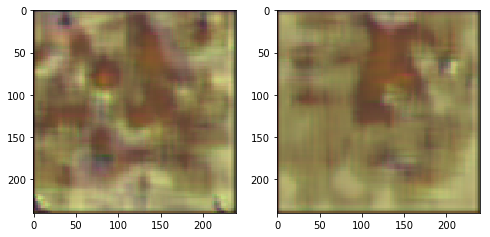

history :  {'acc': [1.0, 1.0], 'loss': [0.014458654448390007, 0.028745671734213829], 'lr': [0.001, 0.001]}
g_loss :  1.07454
history :  {'acc': [1.0, 1.0], 'loss': [0.028048014268279076, 0.0034633625764399767], 'lr': [0.001, 0.001]}
g_loss :  2.04146
history :  {'acc': [1.0, 1.0], 'loss': [0.011040276847779751, 0.0021030327770859003], 'lr': [0.001, 0.001]}
g_loss :  0.712777
history :  {'acc': [1.0, 1.0], 'loss': [0.014859756454825401, 0.028516253456473351], 'lr': [0.001, 0.001]}
g_loss :  1.37132
history :  {'acc': [0.89999997615814209, 0.96666663885116577], 'loss': [0.25632753968238831, 0.044489461928606033], 'lr': [0.001, 0.001]}
g_loss :  1.41072


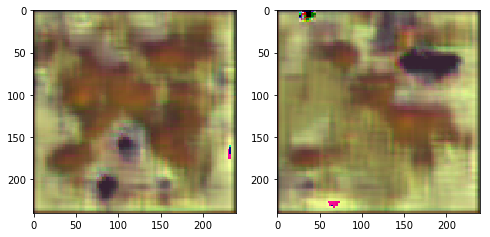

history :  {'acc': [1.0, 0.89999997615814209], 'loss': [0.015186534263193607, 0.37424817681312561], 'lr': [0.001, 0.001]}
g_loss :  1.69294
history :  {'acc': [1.0, 0.89999997615814209], 'loss': [0.045657780021429062, 0.1552700400352478], 'lr': [0.001, 0.001]}
g_loss :  0.53727
history :  {'acc': [0.96666663885116577, 0.96666663885116577], 'loss': [0.076890476047992706, 0.085739254951477051], 'lr': [0.001, 0.001]}
g_loss :  2.71165
history :  {'acc': [0.89999997615814209, 1.0], 'loss': [0.20411819219589233, 0.021136460825800896], 'lr': [0.001, 0.001]}
g_loss :  2.11593
history :  {'acc': [1.0, 0.93333333730697632], 'loss': [0.035967294126749039, 0.11399368196725845], 'lr': [0.001, 0.001]}
g_loss :  1.90286


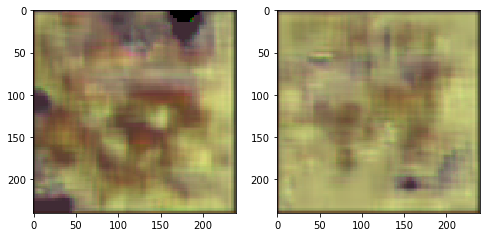

history :  {'acc': [1.0, 1.0], 'loss': [0.016438273712992668, 0.0062135676853358746], 'lr': [0.001, 0.001]}
g_loss :  2.17004
history :  {'acc': [0.96666663885116577, 1.0], 'loss': [0.044301576912403107, 0.017348326742649078], 'lr': [0.001, 0.001]}
g_loss :  0.680068
history :  {'acc': [1.0, 1.0], 'loss': [0.037720758467912674, 0.068116419017314911], 'lr': [0.001, 0.001]}
g_loss :  1.11247
history :  {'acc': [1.0, 1.0], 'loss': [0.0041950056329369545, 0.0011783189838752151], 'lr': [0.001, 0.001]}
g_loss :  1.09769
history :  {'acc': [1.0, 1.0], 'loss': [0.0044202064163982868, 0.014946116134524345], 'lr': [0.001, 0.001]}
g_loss :  1.64


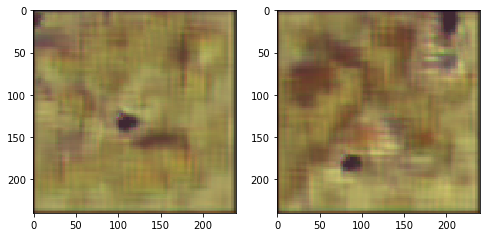

history :  {'acc': [0.96666663885116577, 0.96666663885116577], 'loss': [0.070406392216682434, 0.074187152087688446], 'lr': [0.001, 0.001]}
g_loss :  1.74656
history :  {'acc': [1.0, 1.0], 'loss': [0.018528938293457031, 0.015760699287056923], 'lr': [0.001, 0.001]}
g_loss :  2.66247
history :  {'acc': [0.96666663885116577, 1.0], 'loss': [0.34123724699020386, 0.02379225566983223], 'lr': [0.001, 0.001]}
g_loss :  1.61181
history :  {'acc': [1.0, 1.0], 'loss': [0.013383657671511173, 0.0099497456103563309], 'lr': [0.001, 0.001]}
g_loss :  0.223135
history :  {'acc': [0.96666663885116577, 1.0], 'loss': [0.029722344130277634, 0.0090289842337369919], 'lr': [0.001, 0.001]}
g_loss :  1.53183


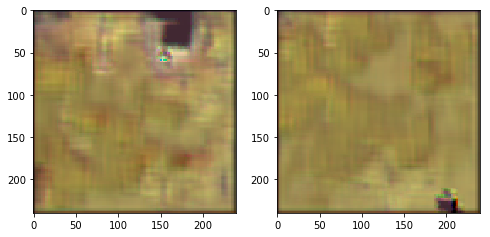

history :  {'acc': [0.96666663885116577, 0.89999997615814209], 'loss': [0.12717045843601227, 0.13924640417098999], 'lr': [0.001, 0.001]}
g_loss :  1.19209e-07
history :  {'acc': [0.96666663885116577, 0.96666663885116577], 'loss': [0.16059474647045135, 0.092688106000423431], 'lr': [0.001, 0.001]}
g_loss :  0.53727
history :  {'acc': [0.93333333730697632, 0.89999997615814209], 'loss': [0.22295373678207397, 0.26534241437911987], 'lr': [0.001, 0.001]}
g_loss :  0.53727
history :  {'acc': [0.96666663885116577, 1.0], 'loss': [0.05001198872923851, 0.035743720829486847], 'lr': [0.001, 0.001]}
g_loss :  0.65457
history :  {'acc': [0.83333331346511841, 0.96666663885116577], 'loss': [0.35219937562942505, 0.054182730615139008], 'lr': [0.001, 0.001]}
g_loss :  0.275131


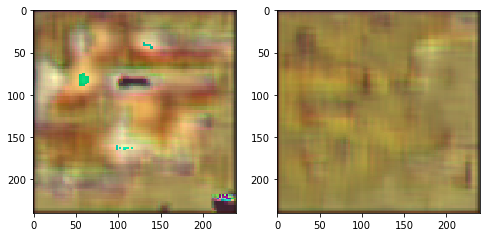

history :  {'acc': [0.89999997615814209, 0.93333333730697632], 'loss': [0.1301177442073822, 0.19383916258811951], 'lr': [0.001, 0.001]}
g_loss :  1.19209e-07
history :  {'acc': [0.93333333730697632, 1.0], 'loss': [0.10797031223773956, 0.0084895025938749313], 'lr': [0.001, 0.001]}
g_loss :  0.53727
history :  {'acc': [0.93333333730697632, 1.0], 'loss': [0.4801630973815918, 0.0096416128799319267], 'lr': [0.001, 0.001]}
g_loss :  1.19209e-07
history :  {'acc': [0.96666663885116577, 0.89999997615814209], 'loss': [0.078320533037185669, 0.18406370282173157], 'lr': [0.001, 0.001]}
g_loss :  1.19209e-07
history :  {'acc': [0.96666663885116577, 0.96666663885116577], 'loss': [0.15761329233646393, 0.086484760046005249], 'lr': [0.001, 0.001]}
g_loss :  1.19209e-07


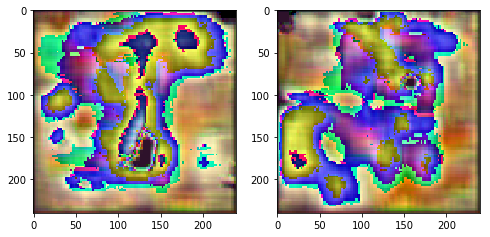

history :  {'acc': [0.93333333730697632, 0.96666663885116577], 'loss': [0.087643861770629883, 0.056363072246313095], 'lr': [0.001, 0.001]}
g_loss :  0.132584
history :  {'acc': [0.96666663885116577, 1.0], 'loss': [0.046105913817882538, 0.030698223039507866], 'lr': [0.001, 0.001]}
g_loss :  0.53727
history :  {'acc': [0.93333333730697632, 0.96666663885116577], 'loss': [0.22046160697937012, 0.056092977523803711], 'lr': [0.001, 0.001]}
g_loss :  0.53727
history :  {'acc': [0.96666663885116577, 0.96666663885116577], 'loss': [0.1232134997844696, 0.12151457369327545], 'lr': [0.001, 0.001]}
g_loss :  0.53727
history :  {'acc': [1.0, 1.0], 'loss': [0.0077441604807972908, 0.0038084124680608511], 'lr': [0.001, 0.001]}
g_loss :  0.53727


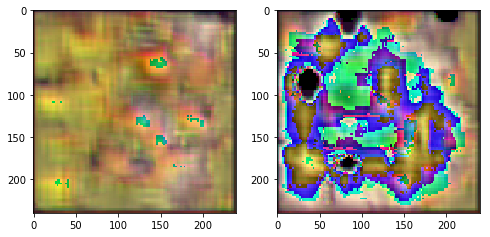

history :  {'acc': [1.0, 1.0], 'loss': [0.012185377068817616, 0.0087153501808643341], 'lr': [0.001, 0.001]}
g_loss :  0.0896612
history :  {'acc': [1.0, 1.0], 'loss': [0.0087039684876799583, 0.0041826954111456871], 'lr': [0.001, 0.001]}
g_loss :  3.80032e-05
history :  {'acc': [1.0, 1.0], 'loss': [0.00467321602627635, 0.0058580534532666206], 'lr': [0.001, 0.001]}
g_loss :  0.15451
history :  {'acc': [1.0, 1.0], 'loss': [0.004720381461083889, 0.0051537943072617054], 'lr': [0.001, 0.001]}
g_loss :  0.000116759
history :  {'acc': [1.0, 1.0], 'loss': [0.012332427315413952, 0.0090285642072558403], 'lr': [0.001, 0.001]}
g_loss :  0.564203


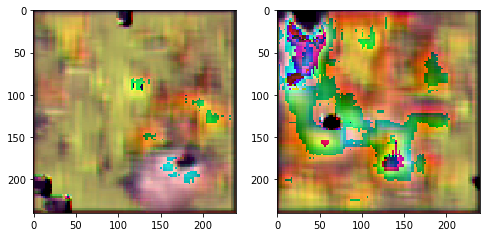

history :  {'acc': [1.0, 1.0], 'loss': [0.013517973944544792, 0.0059793228283524513], 'lr': [0.001, 0.001]}
g_loss :  0.618422
history :  {'acc': [1.0, 1.0], 'loss': [0.0013200936373323202, 0.00085505167953670025], 'lr': [0.001, 0.001]}
g_loss :  0.660794
history :  {'acc': [0.96666663885116577, 0.96666663885116577], 'loss': [0.094930514693260193, 0.04813491553068161], 'lr': [0.001, 0.001]}
g_loss :  8.79256e-05
history :  {'acc': [0.93333333730697632, 0.96666663885116577], 'loss': [0.10535883158445358, 0.052192315459251404], 'lr': [0.001, 0.001]}
g_loss :  3.26862
history :  {'acc': [0.96666663885116577, 0.96666663885116577], 'loss': [0.1219535619020462, 0.096930928528308868], 'lr': [0.001, 0.001]}
g_loss :  3.18089


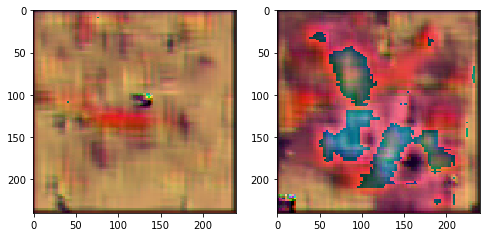

history :  {'acc': [0.96666663885116577, 1.0], 'loss': [0.080528616905212402, 0.018000101670622826], 'lr': [0.001, 0.001]}
g_loss :  0.0921541
history :  {'acc': [0.93333333730697632, 0.96666663885116577], 'loss': [0.16850863397121429, 0.065187342464923859], 'lr': [0.001, 0.001]}
g_loss :  3.94788
history :  {'acc': [1.0, 1.0], 'loss': [0.011535331606864929, 0.019926425069570541], 'lr': [0.001, 0.001]}
g_loss :  0.778132
history :  {'acc': [1.0, 1.0], 'loss': [0.021692996844649315, 0.012718106620013714], 'lr': [0.001, 0.001]}
g_loss :  0.221649
history :  {'acc': [1.0, 1.0], 'loss': [0.010135405696928501, 0.0071123288944363594], 'lr': [0.001, 0.001]}
g_loss :  1.07495


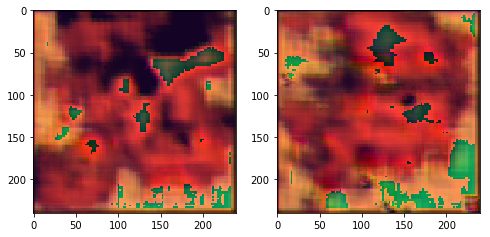

history :  {'acc': [1.0, 1.0], 'loss': [0.001427481765858829, 0.0019152617314830422], 'lr': [0.001, 0.001]}
g_loss :  0.0363155
history :  {'acc': [1.0, 1.0], 'loss': [0.00066484120907261968, 0.00098964874632656574], 'lr': [0.001, 0.001]}
g_loss :  1.07454
history :  {'acc': [1.0, 1.0], 'loss': [0.001853961031883955, 0.0025993576273322105], 'lr': [0.001, 0.001]}
g_loss :  0.53727
history :  {'acc': [1.0, 1.0], 'loss': [0.0052924994379281998, 0.0084828613325953484], 'lr': [0.001, 0.001]}
g_loss :  0.10453
history :  {'acc': [1.0, 1.0], 'loss': [0.00487911282107234, 0.001720646396279335], 'lr': [0.001, 0.001]}
g_loss :  14.2117


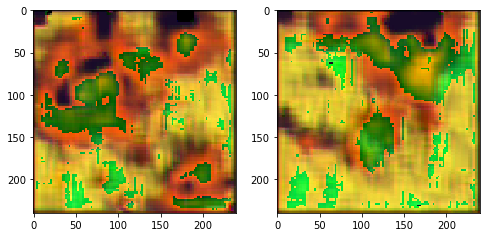

history :  {'acc': [0.89999997615814209, 0.96666663885116577], 'loss': [0.28888806700706482, 0.091105334460735321], 'lr': [0.001, 0.001]}
g_loss :  8.29193
history :  {'acc': [0.93333333730697632, 1.0], 'loss': [0.26532894372940063, 0.039030019193887711], 'lr': [0.001, 0.001]}
g_loss :  3.48751
history :  {'acc': [1.0, 1.0], 'loss': [1.5830602933419868e-05, 8.1322323239874095e-06], 'lr': [0.001, 0.001]}
g_loss :  1.08395
history :  {'acc': [1.0, 1.0], 'loss': [3.748216840904206e-05, 4.0023147448664531e-05], 'lr': [0.001, 0.001]}
g_loss :  0.971941
history :  {'acc': [1.0, 1.0], 'loss': [5.3520823712460697e-05, 0.00012161525955889374], 'lr': [0.001, 0.001]}
g_loss :  0.537701


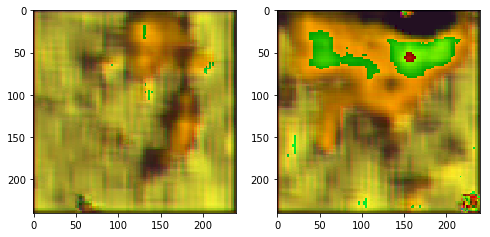

history :  {'acc': [1.0, 1.0], 'loss': [0.00036289816489443183, 0.00094775704201310873], 'lr': [0.001, 0.001]}
g_loss :  1.08811
history :  {'acc': [1.0, 1.0], 'loss': [0.0020651025697588921, 0.0032037354540079832], 'lr': [0.001, 0.001]}
g_loss :  0.540583
history :  {'acc': [1.0, 1.0], 'loss': [0.0045994063839316368, 0.0056830504909157753], 'lr': [0.001, 0.001]}
g_loss :  0.334083
history :  {'acc': [1.0, 1.0], 'loss': [0.0060303378850221634, 0.0042942753061652184], 'lr': [0.001, 0.001]}
g_loss :  1.08502
history :  {'acc': [1.0, 1.0], 'loss': [0.0055584055371582508, 0.0040902909822762012], 'lr': [0.001, 0.001]}
g_loss :  0.739792


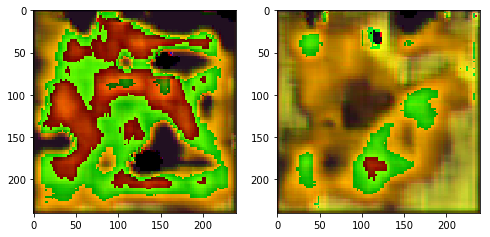

history :  {'acc': [1.0, 1.0], 'loss': [0.0022406275384128094, 0.0044004712253808975], 'lr': [0.001, 0.001]}
g_loss :  1.32079
history :  {'acc': [1.0, 1.0], 'loss': [0.00022460221953224391, 0.00017617869889363647], 'lr': [0.001, 0.001]}
g_loss :  0.83285
history :  {'acc': [1.0, 1.0], 'loss': [0.00037976505700498819, 0.00057725090300664306], 'lr': [0.001, 0.001]}
g_loss :  0.916205
history :  {'acc': [1.0, 1.0], 'loss': [0.00025198262301273644, 0.00012184760271338746], 'lr': [0.001, 0.001]}
g_loss :  0.0341428
history :  {'acc': [1.0, 1.0], 'loss': [0.00021673663286492229, 0.00026750206598080695], 'lr': [0.001, 0.001]}
g_loss :  0.480381


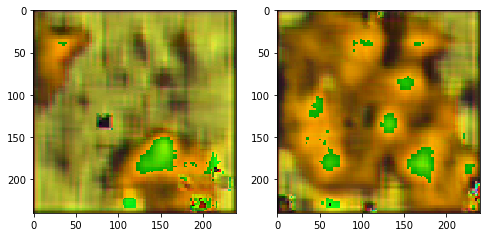

history :  {'acc': [1.0, 1.0], 'loss': [0.00015731302846688777, 8.8763095845934004e-05], 'lr': [0.001, 0.001]}
g_loss :  0.189621
history :  {'acc': [1.0, 1.0], 'loss': [0.00096386548830196261, 3.8632799260085449e-05], 'lr': [0.001, 0.001]}
g_loss :  0.100207
history :  {'acc': [1.0, 1.0], 'loss': [0.00011815739708254114, 0.00015171684208326042], 'lr': [0.001, 0.001]}
g_loss :  0.568084
history :  {'acc': [1.0, 1.0], 'loss': [2.7614889404503629e-05, 0.0021291209850460291], 'lr': [0.001, 0.001]}
g_loss :  0.315516
history :  {'acc': [1.0, 1.0], 'loss': [0.00029157038079574704, 0.00012595883163157851], 'lr': [0.001, 0.001]}
g_loss :  0.244001


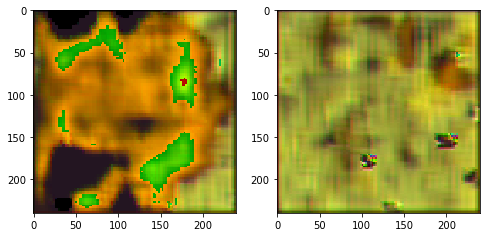

history :  {'acc': [1.0, 1.0], 'loss': [9.7408257715869695e-05, 4.4849552068626508e-05], 'lr': [0.001, 0.001]}
g_loss :  0.00396659
history :  {'acc': [0.96666663885116577, 1.0], 'loss': [0.041499782353639603, 0.0197597686201334], 'lr': [0.001, 0.001]}
g_loss :  0.554899
history :  {'acc': [1.0, 1.0], 'loss': [0.0044755828566849232, 0.0062392274849116802], 'lr': [0.001, 0.001]}
g_loss :  0.0841119
history :  {'acc': [1.0, 1.0], 'loss': [0.010885914787650108, 0.007292446680366993], 'lr': [0.001, 0.001]}
g_loss :  0.0604489
history :  {'acc': [1.0, 1.0], 'loss': [0.0023096541408449411, 0.0022400117013603449], 'lr': [0.001, 0.001]}
g_loss :  0.520809


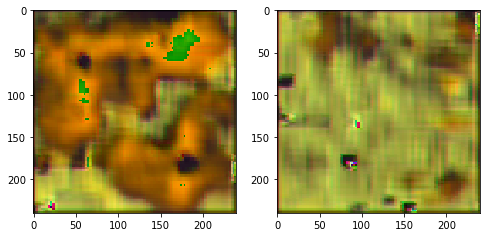

history :  {'acc': [1.0, 1.0], 'loss': [0.00072285800706595182, 0.00058886955957859755], 'lr': [0.001, 0.001]}
g_loss :  0.20779
history :  {'acc': [1.0, 1.0], 'loss': [0.0013298798585310578, 0.00042167937499471009], 'lr': [0.001, 0.001]}
g_loss :  0.00618247
history :  {'acc': [1.0, 1.0], 'loss': [0.00010456763993715867, 3.2579657272435725e-05], 'lr': [0.001, 0.001]}
g_loss :  0.749202
history :  {'acc': [1.0, 1.0], 'loss': [5.7712572015589103e-05, 3.3541760785738006e-05], 'lr': [0.001, 0.001]}
g_loss :  0.170469
history :  {'acc': [1.0, 1.0], 'loss': [0.00022835942218080163, 0.00015275264740921557], 'lr': [0.001, 0.001]}
g_loss :  0.172811


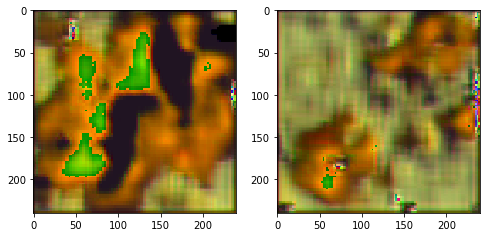

history :  {'acc': [1.0, 1.0], 'loss': [0.00082411058247089386, 0.001564978389069438], 'lr': [0.001, 0.001]}
g_loss :  0.203872
history :  {'acc': [1.0, 1.0], 'loss': [1.505833279225044e-05, 2.3042937755235471e-05], 'lr': [0.001, 0.001]}
g_loss :  0.284751
history :  {'acc': [1.0, 1.0], 'loss': [0.0039860145188868046, 0.0012779155513271689], 'lr': [0.001, 0.001]}
g_loss :  0.0594047
history :  {'acc': [1.0, 1.0], 'loss': [0.0050421534106135368, 0.0012464654864743352], 'lr': [0.001, 0.001]}
g_loss :  9.68239e-05
history :  {'acc': [1.0, 1.0], 'loss': [0.00044541273382492363, 0.00030550765222869813], 'lr': [0.001, 0.001]}
g_loss :  0.0416767


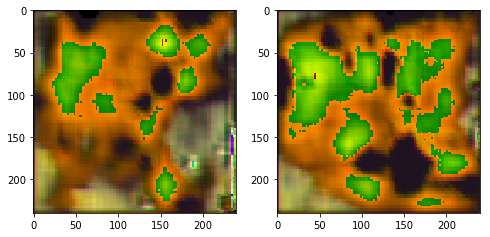

history :  {'acc': [1.0, 1.0], 'loss': [0.0038059358485043049, 0.0044746478088200092], 'lr': [0.001, 0.001]}
g_loss :  4.09742e-05
history :  {'acc': [1.0, 1.0], 'loss': [0.0027919425629079342, 0.00056013907305896282], 'lr': [0.001, 0.001]}
g_loss :  0.00471976
history :  {'acc': [1.0, 1.0], 'loss': [0.000117644747660961, 8.9324246800970286e-05], 'lr': [0.001, 0.001]}
g_loss :  0.132213
history :  {'acc': [1.0, 1.0], 'loss': [0.0089326677843928337, 0.012249557301402092], 'lr': [0.001, 0.001]}
g_loss :  0.0138987
history :  {'acc': [0.96666663885116577, 0.96666663885116577], 'loss': [0.037583999335765839, 0.034949701279401779], 'lr': [0.001, 0.001]}
g_loss :  0.00389154


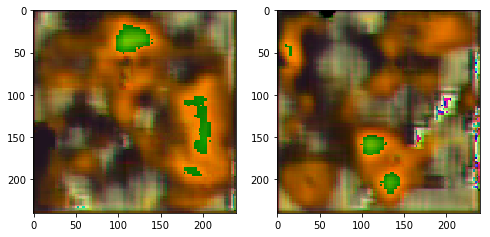

history :  {'acc': [1.0, 1.0], 'loss': [0.010910823941230774, 0.0068052466958761215], 'lr': [0.001, 0.001]}
g_loss :  0.00962777
history :  {'acc': [1.0, 1.0], 'loss': [0.032538708299398422, 0.0074735567905008793], 'lr': [0.001, 0.001]}
g_loss :  0.0905927
history :  {'acc': [1.0, 1.0], 'loss': [0.0014242094475775957, 0.0018367243465036154], 'lr': [0.001, 0.001]}
g_loss :  0.166794
history :  {'acc': [1.0, 1.0], 'loss': [0.0099600674584507942, 0.016749328002333641], 'lr': [0.001, 0.001]}
g_loss :  0.714482
history :  {'acc': [1.0, 1.0], 'loss': [0.00055024714674800634, 0.00025682867271825671], 'lr': [0.001, 0.001]}
g_loss :  0.335749


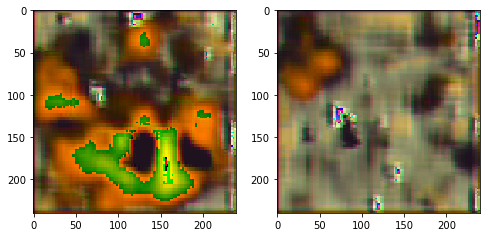

history :  {'acc': [1.0, 1.0], 'loss': [0.0059027685783803463, 0.018466388806700706], 'lr': [0.001, 0.001]}
g_loss :  0.0150273
history :  {'acc': [1.0, 1.0], 'loss': [0.0028063557110726833, 0.0024331971071660519], 'lr': [0.001, 0.001]}
g_loss :  0.0426747
history :  {'acc': [1.0, 1.0], 'loss': [0.0022766122128814459, 0.004947996698319912], 'lr': [0.001, 0.001]}
g_loss :  0.00135398
history :  {'acc': [1.0, 1.0], 'loss': [0.0011029711458832026, 0.0016617983346804976], 'lr': [0.001, 0.001]}
g_loss :  0.0013389
history :  {'acc': [1.0, 1.0], 'loss': [0.0011459954548627138, 0.00038143087294884026], 'lr': [0.001, 0.001]}
g_loss :  0.250133


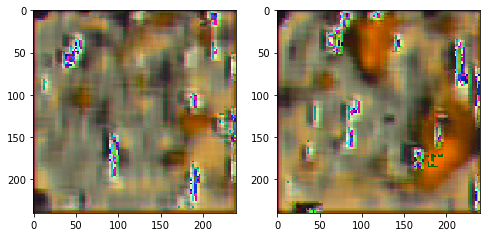

history :  {'acc': [0.96666663885116577, 0.96666663885116577], 'loss': [0.039163265377283096, 0.032134391367435455], 'lr': [0.001, 0.001]}
g_loss :  1.09276e-06
history :  {'acc': [1.0, 1.0], 'loss': [0.0011318296892568469, 0.0042295283637940884], 'lr': [0.001, 0.001]}
g_loss :  1.78814e-07
history :  {'acc': [1.0, 1.0], 'loss': [0.019267728552222252, 0.034474983811378479], 'lr': [0.001, 0.001]}
g_loss :  0.000547721
history :  {'acc': [1.0, 1.0], 'loss': [0.020115932449698448, 0.0059128007851541042], 'lr': [0.001, 0.001]}
g_loss :  0.381367
history :  {'acc': [1.0, 1.0], 'loss': [0.00026802398497238755, 8.5221981862559915e-05], 'lr': [0.001, 0.001]}
g_loss :  0.0663632


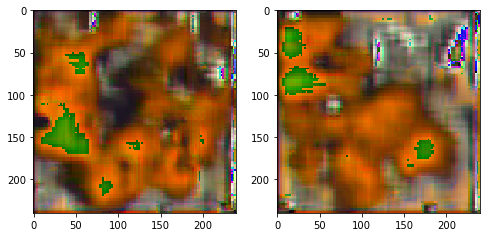

history :  {'acc': [1.0, 1.0], 'loss': [0.016987206414341927, 0.018186483532190323], 'lr': [0.001, 0.001]}
g_loss :  0.180473
history :  {'acc': [0.96666663885116577, 1.0], 'loss': [0.13269065320491791, 0.00066720234462991357], 'lr': [0.001, 0.001]}
g_loss :  0.000364555
history :  {'acc': [1.0, 0.96666663885116577], 'loss': [0.00088501744903624058, 0.057699903845787048], 'lr': [0.001, 0.001]}
g_loss :  0.0088398
history :  {'acc': [1.0, 1.0], 'loss': [0.028593705967068672, 0.0017036328790709376], 'lr': [0.001, 0.001]}
g_loss :  0.0178472
history :  {'acc': [1.0, 1.0], 'loss': [0.0050718570128083229, 0.0024124898482114077], 'lr': [0.001, 0.001]}
g_loss :  1.32887


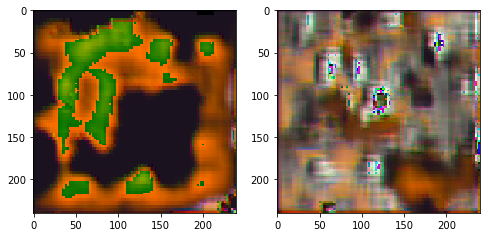

history :  {'acc': [0.96666663885116577, 0.96666663885116577], 'loss': [0.077457383275032043, 0.080424576997756958], 'lr': [0.001, 0.001]}
g_loss :  0.0739245
history :  {'acc': [1.0, 1.0], 'loss': [0.0068188398145139217, 0.0020880729425698519], 'lr': [0.001, 0.001]}
g_loss :  1.00644
history :  {'acc': [0.96666663885116577, 1.0], 'loss': [0.084837883710861206, 0.028695642948150635], 'lr': [0.001, 0.001]}
g_loss :  0.219285
history :  {'acc': [1.0, 1.0], 'loss': [0.012559234164655209, 0.0038990597240626812], 'lr': [0.001, 0.001]}
g_loss :  1.52035
history :  {'acc': [0.96666663885116577, 1.0], 'loss': [0.080842114984989166, 0.042505841702222824], 'lr': [0.001, 0.001]}
g_loss :  0.476199


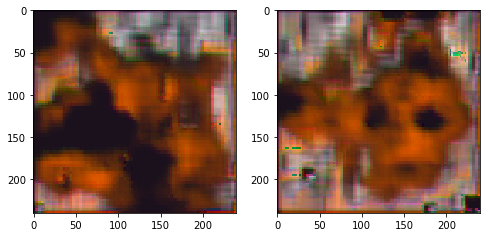

history :  {'acc': [0.96666663885116577, 0.96666663885116577], 'loss': [0.094615302979946136, 0.050725419074296951], 'lr': [0.001, 0.001]}
g_loss :  0.0435083
history :  {'acc': [1.0, 1.0], 'loss': [0.071349993348121643, 0.025422241538763046], 'lr': [0.001, 0.001]}
g_loss :  0.746167
history :  {'acc': [0.86666667461395264, 0.96666663885116577], 'loss': [0.24834902584552765, 0.18604236841201782], 'lr': [0.001, 0.001]}
g_loss :  2.20991
history :  {'acc': [0.89999997615814209, 0.96666663885116577], 'loss': [0.37181380391120911, 0.15752634406089783], 'lr': [0.001, 0.001]}
g_loss :  0.0842337
history :  {'acc': [1.0, 1.0], 'loss': [0.017113534733653069, 0.045504424721002579], 'lr': [0.001, 0.001]}
g_loss :  8.71327e-05


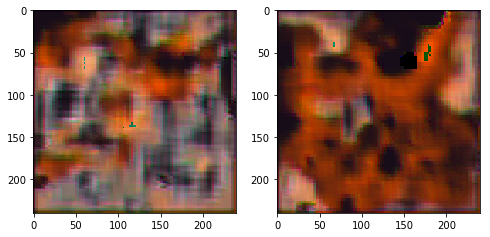

history :  {'acc': [0.80000001192092896, 0.86666667461395264], 'loss': [0.46156767010688782, 0.20845450460910797], 'lr': [0.001, 0.001]}
g_loss :  0.00100542
history :  {'acc': [0.96666663885116577, 0.96666663885116577], 'loss': [0.16467362642288208, 0.1337861567735672], 'lr': [0.001, 0.001]}
g_loss :  1.02521e-06
history :  {'acc': [1.0, 1.0], 'loss': [0.013193064369261265, 0.012279572896659374], 'lr': [0.001, 0.001]}
g_loss :  1.66893e-07
history :  {'acc': [1.0, 1.0], 'loss': [0.014144139364361763, 0.010282293893396854], 'lr': [0.001, 0.001]}
g_loss :  1.19209e-07
history :  {'acc': [1.0, 1.0], 'loss': [0.010227138176560402, 0.014564649201929569], 'lr': [0.001, 0.001]}
g_loss :  1.19209e-07


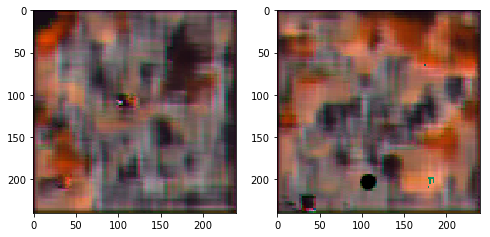

history :  {'acc': [0.96666663885116577, 0.93333333730697632], 'loss': [0.064023241400718689, 0.076226390898227692], 'lr': [0.001, 0.001]}
g_loss :  8.34473e-07
history :  {'acc': [1.0, 1.0], 'loss': [0.01104414090514183, 0.006402208935469389], 'lr': [0.001, 0.001]}
g_loss :  1.19209e-07
history :  {'acc': [1.0, 1.0], 'loss': [0.010624338872730732, 0.010362443514168262], 'lr': [0.001, 0.001]}
g_loss :  1.02178e-05
history :  {'acc': [1.0, 1.0], 'loss': [0.016016636043787003, 0.01471968088299036], 'lr': [0.001, 0.001]}
g_loss :  1.3908e-06
history :  {'acc': [1.0, 1.0], 'loss': [0.0022930693812668324, 0.0037271124310791492], 'lr': [0.001, 0.001]}
g_loss :  1.19209e-07


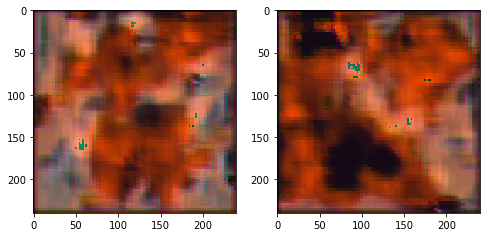

history :  {'acc': [0.96666663885116577, 0.96666663885116577], 'loss': [0.07768867164850235, 0.064548484981060028], 'lr': [0.001, 0.001]}


In [ ]:
epochs = 20000
batch_size = 30
save_interval= 5
half_batch = int(batch_size / 2)

z = Input(shape=(100,))
img = generator(z)
discriminator.trainable = False
valid = discriminator(img)
combined = Model(z, valid)
# combined.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))
combined.compile(loss='binary_crossentropy', optimizer='nadam')

for epoch in range(epochs):
    d_input, d_output = getData(half_batch)
    discriminator.trainable = True
    reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.6,
              patience=10, min_lr=0.001)

    h = discriminator.fit(d_input, d_output, epochs = 2, verbose=0, callbacks=[reduce_lr, myPlot])
    print('history : ', h.history)
    
    # ---------------------
    #  Train Generator
    # ---------------------

    noise = np.random.normal(0, 1, (batch_size, 100))

    # The generator wants the discriminator to label the generated samples
    # as valid (ones)
    valid_y = np.array([1] * batch_size)

    # Train the generator
    g_loss = combined.train_on_batch(noise, valid_y)
    print('g_loss : ', g_loss)
    
    if epoch % save_interval == 0:
        save_imgs(epoch)